In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import string
import re
import nltk

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from collections import Counter 

file_path = 'C:\\Users\\18014\\Desktop\\imdb_labelled.txt'
sentences, labels = [], []

#Stripping space and organizing data
with open(file_path, 'r') as file:
    for line in file:
        sentence, label = line.strip().split('\t')
        sentences.append(sentence)
        labels.append(int(label))

data = pd.DataFrame({'sentence': sentences, 'label': labels})

print("Original data:")
print(data.head())

Original data:
                                            sentence  label
0  A very, very, very slow-moving, aimless movie ...      0
1  Not sure who was more lost - the flat characte...      0
2  Attempting artiness with black & white and cle...      0
3       Very little music or anything to speak of.        0
4  The best scene in the movie was when Gerardo i...      1


In [2]:
#Checking for unusual characters (emojis, non-English, etc.)
def find_unusual_characters(text):
    return re.findall(r'[^\x00-\x7F]+', text)

#Count and sum unusual characters
all_unusual_chars = data['sentence'].apply(find_unusual_characters).sum()
unusual_char_counts = Counter(all_unusual_chars)
print(unusual_char_counts)

Counter({'Â–': 5, 'Ã©': 4, 'Â…': 2, 'Ã¥': 1, 'Â—': 1})


In [3]:
#Cleaning the sentences
def clean_text(text):
    #Removing unusual characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    #All text lowercase
    text = text.lower()
    
    #Removing all punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    
    #Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#Cleaning the sentences in the dataframe
data['cleaned_sentence'] = data['sentence'].apply(clean_text)


In [4]:
#Checking if our unusual character removal worked
all_unusual_chars_cleaned = data['cleaned_sentence'].apply(find_unusual_characters).sum()
unusual_char_counts_cleaned = Counter(all_unusual_chars_cleaned)

print(unusual_char_counts_cleaned)

Counter()


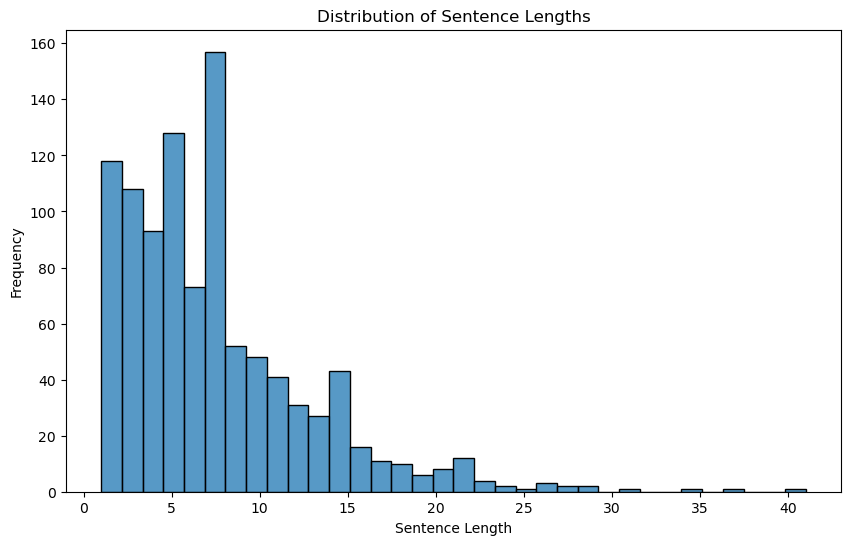

Minimum sentence length: 1
Maximum sentence length: 41
Mean sentence length: 7.542


In [5]:
#Calculating sentence length
sentence_lengths = data['cleaned_sentence'].apply(lambda x: len(x.split()))

#Plotting distribution of sentence lengths
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

#Statistics on sentence length
print(f"Minimum sentence length: {min(sentence_lengths)}")
print(f"Maximum sentence length: {max(sentence_lengths)}")
print(f"Mean sentence length: {np.mean(sentence_lengths)}")

In [6]:
#Tokenizing text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_sentence'])
sequences = tokenizer.texts_to_sequences(data['cleaned_sentence'])

#Calculate and print vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 3052


In [7]:
#Establishing maximum sequenxe length
max_sequence_length = 50
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

#Print a padded example (first sentence)
print("Example of a single padded sequence:")
print(padded_sequences[0])

Example of a single padded sequence:
[1070 1071    1 1072 1073  293   67    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [8]:
#Train-test-validation split with 70-15-15 split
labels = data['label'].values
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [9]:
#Saving the dataset to a CSV file
prepared_data = data[['cleaned_sentence', 'label']]
prepared_data.to_csv(r'C:\Users\18014\Desktop\cleaned_dataset.csv', index=False)

In [10]:
#Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)


#Defining the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Building the model
model.build(input_shape=(None, max_sequence_length))
model.summary()

#Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │       305,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,209 (2.12 MB)

 Trainable params: 556,209 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4919 - loss: 0.6938 - val_accuracy: 0.6267 - val_loss: 0.6910
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5828 - loss: 0.6893 - val_accuracy: 0.6733 - val_loss: 0.6842
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7267 - loss: 0.6689 - val_accuracy: 0.5067 - val_loss: 0.6780
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7328 - loss: 0.5866 - val_accuracy: 0.8000 - val_loss: 0.5214
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8585 - loss: 0.4631 - val_accuracy: 0.5800 - val_loss: 0.6991
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7710 - loss: 0.4620 - val_accuracy: 0.5933 - val_loss: 0.6571
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8311 - loss: 0.4357 - val_accuracy: 0.6600 - val_loss: 0.6366


In [11]:
#Accuracy test
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7377 - loss: 0.5652
Test Accuracy: 0.7600


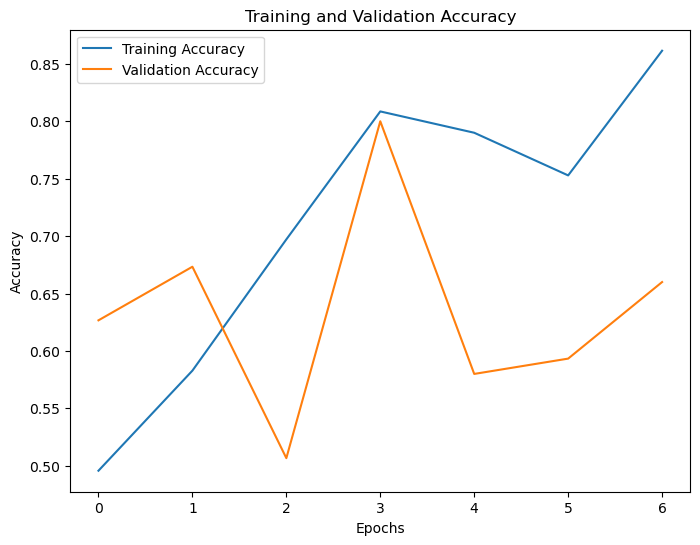

In [12]:
#Plotting training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

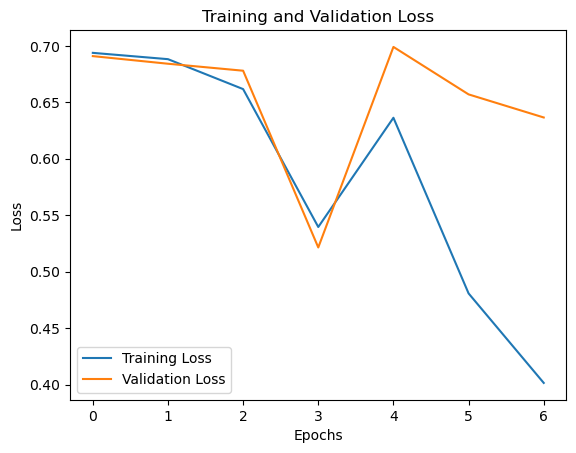

In [13]:
#Plotting training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
model.save(r'C:\Users\18014\Desktop\sentiment_analysis_model.h5')

In [15]:
#Cacluating predictions on the test set
y_pred = (model.predict(X_test) >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        73
           1       0.71      0.91      0.80        77

    accuracy                           0.76       150
   macro avg       0.78      0.76      0.75       150
weighted avg       0.78      0.76      0.75       150

